### Create demographics tables for paper from video info

In [13]:
import re
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment, PatternFill
import os

def process_seizure_data(file_path, output_excel_path):
    # Read the file
    with open(file_path, 'r') as file:
        content = file.read()

    # Split the content into patient blocks
    patient_blocks = re.split(r'\n\n+', content.strip())

    # Create a new workbook and select the active sheet
    wb = Workbook()
    ws = wb.active
    ws.title = "Seizure Data"

    # Define headers
    headers = ["Patient ID", "Video Name", "Seizure Seconds", "Seizure %", "Non-Seizure Seconds", "Non-Seizure %", "Total Seconds"]

    # Style the headers
    for col, header in enumerate(headers, start=1):
        cell = ws.cell(row=1, column=col, value=header)
        cell.font = Font(bold=True)
        cell.fill = PatternFill(start_color="DDDDDD", end_color="DDDDDD", fill_type="solid")
        cell.alignment = Alignment(horizontal="center", vertical="center")

    row = 2  # Start from the second row (after headers)

    for block in patient_blocks:
        # Extract patient ID
        patient_match = re.search(r'Patient \d+.*?(\d+)', block)
        if patient_match:
            patient_id = patient_match.group(1)
        else:
            print(f"Warning: Could not extract patient ID from block:\n{block[:100]}...")
            continue

        # Extract videos information
        videos = re.findall(r'Video Path: (.+)\n\s*Total Frames: (\d+)\n\s*FPS: ([\d.]+)\n\s*Seizure Frames: ([\d.]+)\n\s*Non-Seizure Frames: ([\d.]+)', block)

        if not videos:
            print(f"Warning: Could not extract video information for patient {patient_id}")
            continue

        for video in videos:
            video_path, total_frames, fps, seizure_frames, non_seizure_frames = video
            video_name = os.path.basename(video_path)
            fps = float(fps)
            total_frames = float(total_frames)
            seizure_frames = float(seizure_frames)
            non_seizure_frames = float(non_seizure_frames)

            total_seconds = total_frames / fps
            seizure_seconds = seizure_frames / fps
            non_seizure_seconds = non_seizure_frames / fps

            seizure_percent = (seizure_seconds / total_seconds) * 100
            non_seizure_percent = (non_seizure_seconds / total_seconds) * 100

            # Add data to the worksheet
            ws.append([
                patient_id,
                video_name,
                f"{seizure_seconds:.2f}",
                f"{seizure_percent:.2f}%",
                f"{non_seizure_seconds:.2f}",
                f"{non_seizure_percent:.2f}%",
                f"{total_seconds:.2f}"
            ])

            row += 1

    # Auto-adjust column widths
    for column in ws.columns:
        max_length = 0
        column_letter = column[0].column_letter
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(cell.value)
            except:
                pass
        adjusted_width = (max_length + 2) * 1.2
        ws.column_dimensions[column_letter].width = adjusted_width

    # Save the workbook
    wb.save(output_excel_path)
    print(f"Excel file created successfully: {output_excel_path}")

# Example usage
process_seizure_data(os.path.join(os.getcwd(), "video_info.txt"), "seizure_data_table.xlsx")

Total Frames: 1195476
Seizure Frames:98706	8.26%
Non-seizure Frames:1096770	91.74%...
Excel file created successfully: seizure_data_table.xlsx


## Old Scratch Work

In [2]:
"video_clips\00582992_77952GP00_Seg_0.mp4 0".strip().split()

['video_clips\x0582992_77952GP00_Seg_0.mp4', '0']

In [13]:
# Helpfer functions for the eval loop

import numpy as np
from sklearn.metrics import classification_report

def overall_prediction(predictions, threshold=0.5, seizure_percentage=0.5):
    """
    Determines if a video contains seizure activity based on predictions for each frame.
    
    Parameters:
    predictions (list or numpy array): Array of predictions between 0 and 1.
    threshold (float): Threshold to consider a frame as indicating seizure activity.
    seizure_percentage (float): Percentage of frames that need to indicate seizure activity to classify the video as having seizure activity.
    
    Returns:
    bool: True if the video contains seizure activity, False otherwise.

    **Note**: Not sure what best default values are for threshold, seizure_percentage... ask Cotton?
    """
    raw_predictions = np.array(predictions)
    boundary_predictions = []
    for frame in raw_predictions:
        seizure_frames = np.sum(frame >= threshold)    
        total_frames = len(frame)
        seizure_frames_percentage = seizure_frames / total_frames
        # print(f"raw: {frame}\n%positive: {seizure_frames_percentage}\nNet prediction: {int(seizure_frames_percentage >= seizure_percentage)}")
        boundary_predictions.append(int(seizure_frames_percentage >= seizure_percentage))
    
    return boundary_predictions


In [14]:
ex = np.array(([0.001,0.002,0.932],
              [0.001,0.732,0.032],
              [0.023,0.321,0.112]))
ex_2 = np.array([0.01,0.03,0.08])
ex_3 = np.array([0.124,0.641,0.09])
ex_4 = np.array([0.124,0.441,0.09])
label = [0,1,1]
pred = [0,1,0]

print(np.argmax(ex, axis=1))
print(overall_prediction(ex))
print(overall_prediction(ex_2, seizure_percentage = 0.3))
print(overall_prediction(ex_3, seizure_percentage = 0.3))

[2 1 1]
raw: [0.001 0.002 0.932]
%positive: 0.3333333333333333
Net prediction: 0
raw: [0.001 0.732 0.032]
%positive: 0.3333333333333333
Net prediction: 0
raw: [0.023 0.321 0.112]
%positive: 0.0
Net prediction: 0
[0, 0, 0]


TypeError: object of type 'numpy.float64' has no len()

In [ ]:
for frame in ex:
    print(frame)

[0.001 0.002 0.932]
[0.001 0.732 0.032]
[0.023 0.321 0.112]


In [ ]:
def report_logger(report):
    report_keys = ['precision','recall','f1-score']
    


classification_report(label, pred, output_dict=True)['accuracy']

0.6666666666666666

In [15]:
classification_report(label, pred)

'              precision    recall  f1-score   support\n\n           0       0.50      1.00      0.67         1\n           1       1.00      0.50      0.67         2\n\n    accuracy                           0.67         3\n   macro avg       0.75      0.75      0.67         3\nweighted avg       0.83      0.67      0.67         3\n'

In [16]:
overall_prediction(ex)

raw: [0.001 0.002 0.932]
%positive: 0.3333333333333333
Net prediction: 0
raw: [0.001 0.732 0.032]
%positive: 0.3333333333333333
Net prediction: 0
raw: [0.023 0.321 0.112]
%positive: 0.0
Net prediction: 0


[0, 0, 0]

## Current Work

In [18]:
import numpy as np

### Need to modify via passing y_pred through similar function as seen in top_k_accuracy to handle list of arrays

def confusion_matrix(y_pred, y_real, normalize=None):
    """Compute confusion matrix.

    Args:
        y_pred (list[int] | np.ndarray[int]): Prediction labels.
        y_real (list[int] | np.ndarray[int]): Ground truth labels.
        normalize (str | None): Normalizes confusion matrix over the true
            (rows), predicted (columns) conditions or all the population.
            If None, confusion matrix will not be normalized. Options are
            "true", "pred", "all", None. Default: None.

    Returns:
        np.ndarray: Confusion matrix.
    """
    if normalize not in ['true', 'pred', 'all', None]:
        raise ValueError("normalize must be one of {'true', 'pred', "
                         "'all', None}")

    if isinstance(y_pred, list):
        y_pred = np.array(y_pred)
        if y_pred.dtype == np.int32:
            y_pred = y_pred.astype(np.int64)
    if not isinstance(y_pred, np.ndarray):
        raise TypeError(
            f'y_pred must be list or np.ndarray, but got {type(y_pred)}')
    if not y_pred.dtype == np.int64:
        raise TypeError(
            f'y_pred dtype must be np.int64, but got {y_pred.dtype}')

    if isinstance(y_real, list):
        y_real = np.array(y_real)
        if y_real.dtype == np.int32:
            y_real = y_real.astype(np.int64)
    if not isinstance(y_real, np.ndarray):
        raise TypeError(
            f'y_real must be list or np.ndarray, but got {type(y_real)}')
    if not y_real.dtype == np.int64:
        raise TypeError(
            f'y_real dtype must be np.int64, but got {y_real.dtype}')

    label_set = np.unique(np.concatenate((y_pred, y_real)))
    num_labels = len(label_set)
    max_label = label_set[-1]
    label_map = np.zeros(max_label + 1, dtype=np.int64)
    for i, label in enumerate(label_set):
        label_map[label] = i

    y_pred_mapped = label_map[y_pred]
    y_real_mapped = label_map[y_real]

    confusion_mat = np.bincount(
        num_labels * y_real_mapped + y_pred_mapped,
        minlength=num_labels**2).reshape(num_labels, num_labels)

    with np.errstate(all='ignore'):
        if normalize == 'true':
            confusion_mat = (
                confusion_mat / confusion_mat.sum(axis=1, keepdims=True))
        elif normalize == 'pred':
            confusion_mat = (
                confusion_mat / confusion_mat.sum(axis=0, keepdims=True))
        elif normalize == 'all':
            confusion_mat = (confusion_mat / confusion_mat.sum())
        confusion_mat = np.nan_to_num(confusion_mat)

    return confusion_mat


In [28]:
def top_k_accuracy(scores, labels, topk=(1, )):
    """Calculate top k accuracy score.

    Args:
        scores (list[np.ndarray]): Prediction scores for each class.
        labels (list[int]): Ground truth labels.
        topk (tuple[int]): K value for top_k_accuracy. Default: (1, ).

    Returns:
        list[float]: Top k accuracy score for each k.
    """
    res = []
    labels = np.array(labels)[:, np.newaxis]
    for k in topk:
        max_k_preds = np.argsort(scores, axis=1)[:, -k:][:, ::-1]
        match_array = np.logical_or.reduce(max_k_preds == labels, axis=1)
        topk_acc_score = match_array.sum() / match_array.shape[0]
        res.append(topk_acc_score)

    return max_k_preds, match_array, res

In [29]:
sample_label = np.array([0,0,1,1,0,0])
sample_preds = np.array([[0.3,0.1,0.2],
                        [0.1,0.1,0.1],
                        [0.8,0.9,0.9],
                        [0.9,0.8,0.8],
                        [0.7,0.5,0.4],
                        [0.3,0.1,0.2]])
top_k_accuracy(sample_preds, sample_label, topk=(1,))
# confusion_matrix(sample_preds, sample_label, normalize = None)

(array([[0],
        [2],
        [2],
        [0],
        [0],
        [0]], dtype=int64),
 array([ True, False, False, False,  True,  True]),
 [0.5])

Threshold: 0.01, TP: 0, FP: 0, TN: 15, FN: 5
TPR: 0.0000	FPR: 0.0000


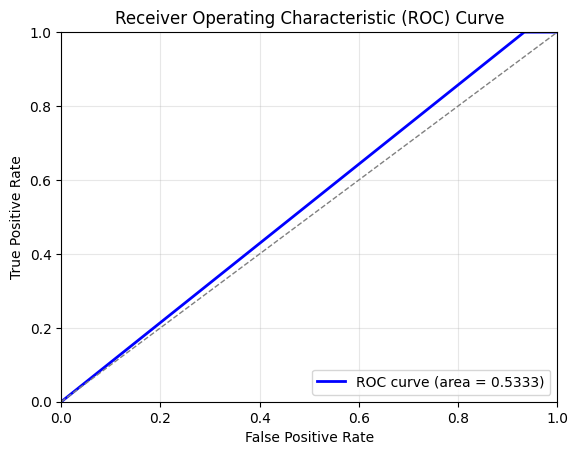

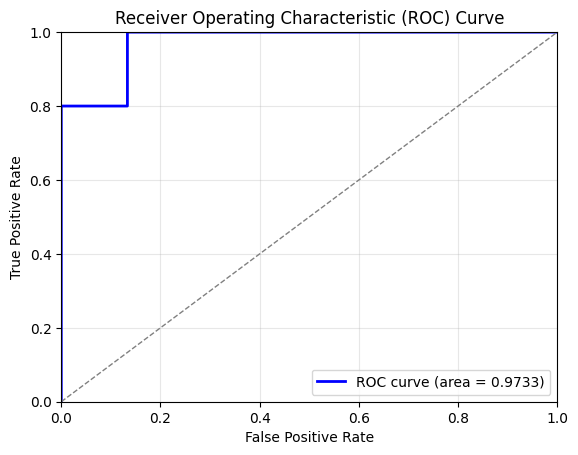

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

labels = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
scores = np.array([0.0025000006, 0.0025000006, 0.0025, 0.0025000004, 0.0025, 0.0025000006, 0.0025000004, 0.0025, 0.0025, 0.0025000004, 0.0025000004, 0.0025, 0.0025000006, 0.0025, 0.0025000004, 0.0025000006, 0.0024999997, 0.0025, 0.0025, 0.0025000004])
better_scores = np.array([0.8, 0.3, 0.6, 0.8, 0.6, 0.5, 0.2, 0.23, 0.13, 0.16, 0.11, 0.08, 0.02, 0.03, 0.06, 0.05, 0.05, 0.12, 0.33, 0.05])
threshold = 0.01

tp = np.sum((scores >= threshold) & (labels == 1))
fn = np.sum((scores < threshold) & (labels == 1))
fp = np.sum((scores >= threshold) & (labels == 0))
tn = np.sum((scores < threshold) & (labels == 0))

print(f"Threshold: {threshold}, TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
fpr = fp / (tn + fp) if (tn + fp) != 0 else 0

print(f"TPR: {tpr:.4f}\tFPR: {fpr:.4f}")

def calculate_tpr_fpr(scores, labels, threshold):
    labels = np.array(labels)
    scores_means = np.array([np.mean(score) for score in scores]) # Probably a better way to handle this
    tp = np.sum((scores_means >= threshold) & (labels == 1))
    fn = np.sum((scores_means < threshold) & (labels == 1))
    fp = np.sum((scores_means >= threshold) & (labels == 0))
    tn = np.sum((scores_means < threshold) & (labels == 0))
    # print(f"Threshold: {threshold}, TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (tn + fp) if (tn + fp) != 0 else 0
        
    return tpr, fpr


def plot_auc_roc(scores, labels):
    # Calculate TPR and FPR for a range of threshold values
    thresholds = np.arange(0, 1, 0.0001)
    tpr_list = []
    fpr_list = []

    for threshold in thresholds:
        tpr, fpr = calculate_tpr_fpr(scores, labels, threshold)
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr_list, tpr_list)

    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr_list, tpr_list, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

plot_auc_roc(scores, labels)
plot_auc_roc(better_scores, labels)

In [5]:
import numpy as np

arr_2d = np.array([[1, 2], [3, 4], [5, 6]])
arr_2d[:,1]


array([2, 4, 6])

In [11]:
import numpy as np

d = np.array([(1, 2)])
e = np.array([(2, 3)])
f = np.array([(3, 4)])
g = np.array([(4, 5)])
h = np.array([(5, 6)])
i = np.array([(6, 7)])

arrays = [d,e,f,g,h,i]


In [12]:
second_elements = [array[0, 1] for array in arrays]

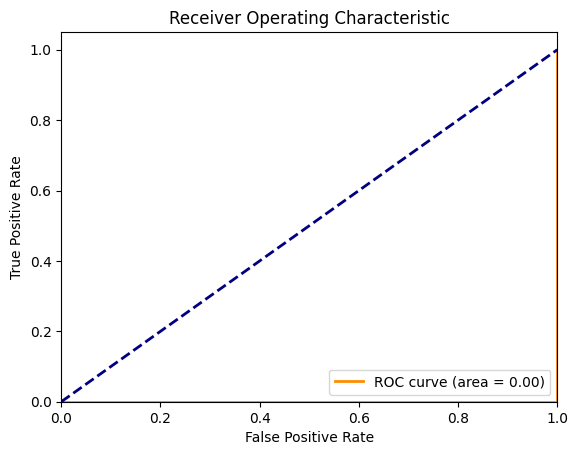

In [22]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Example true binary labels
labels = np.array([0, 0, 0, 0, 0, 1])

# Example predicted probabilities
preds = [np.array([[0.2, 0.8]]),
         np.array([[0.4, 0.6]]),
         np.array([[0.3, 0.7]]),
         np.array([[0.6, 0.4]]),
         np.array([[0.1, 0.9]]),
         np.array([[0.7, 0.3]])]

# Extracting the predicted probabilities for the positive class (class 1)
predicted_probabilities = [pred[0, 1] for pred in preds]

# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(labels, predicted_probabilities)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
